# COMP0124 Multi-agent AI Coursework 
Author: Christina Kouridi

Overview: adaptation of DQN/DDQN for the multi-agent gym environment `Switch-n` . For details please read [the wiki of ma-gym](https://github.com/koulanurag/ma-gym/wiki/).

## Environment set-up and example

### Overview
#### Switch2-v0
![Switch-2](https://raw.githubusercontent.com/koulanurag/ma-gym/master/static/gif/Switch2-v0.gif)
#### Switch4-v0
![Switch-4](https://raw.githubusercontent.com/koulanurag/ma-gym/master/static/gif/Switch4-v0.gif)

`Switch-n` is a grid world environment having `n agents` where each agent wants to move their corresponding home location (marked in boxes outlined in same colors).
Each agent receives only it's local position coordinates. The challenging part of the game is to pass through the narrow corridor; only one agent can pass at a time. They need to coordinate in order to avoid blocking each other when passing through the passage. A reward of +5 is given to each agent for reaching their home cell and a reward of -0.1 per timestep. The episode ends when both agents has reached their home state or a maximum of 100 steps.

Action Space: `0: Down, 1: Left, 2: Up , 3: Right, 4: Noop`

Agent Observation : `Agent Coordinate`

### Download Requirements and Set the Environment
The following command will download the required scripts and set up the environment. 

In [0]:
!rm -rf /content/ma-gym  
!git clone https://github.com/koulanurag/ma-gym.git 
%cd /content/ma-gym 
!pip install -q -e . 
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install -U gym[atari] > /dev/null 2>&1

fatal: destination path 'ma-gym' already exists and is not an empty directory.
[Errno 2] No such file or directory: '/content/ma-gym'
/home/christina
ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /home/christina
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Requirement already up-to-date: setuptools in ./anaconda3/envs/torch/lib/python3.7/site-packages (46.1.3)


In [0]:
%matplotlib inline
import gym
import ma_gym
from ma_gym.wrappers import Monitor
import matplotlib.pyplot as plt
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

#### Example of playing Switch2-v0 using Random Policy

In [0]:
env = wrap_env(gym.make("Switch2-v0")) # Use "Switch4-v0" for the Switch-4 game
done_n = [False for _ in range(env.n_agents)]
ep_reward = 0

obs_n = env.reset()
while not all(done_n):
    obs_n, reward_n, done_n, info = env.step(env.action_space.sample())
    ep_reward += sum(reward_n)
    env.render()
env.close()
# To improve the training efficiency, render() is not necessary during the training.
# We provide the render and video code here just want to demonstrate how to debugging and analysis.
show_video()

/home/christina/anaconda3/envs/torch/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Switch2-v0

In [0]:
#@title DDQN/(DQN) Agent code { form-width: "30%" }

from collections import deque, namedtuple

import numpy as np
import random
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


Transition = namedtuple(
            'transition', 
            ['state', 'action', 'reward', 'next_state', 'done'])


class ReplayBuffer:
    def __init__(self, buffer_size: int) -> None:
        self.capacity = buffer_size

        # Sampling would be faster if a list, but deque takes care of pushing stale samples
        # off the stack for me.
        self.memory = deque(maxlen=buffer_size)

    def __len__(self):
        return len(self.memory)

    def add(self, state: torch.tensor, action: torch.tensor, reward: torch.tensor, next_state: torch.tensor, done: bool) -> None:
        self.memory.append(Transition(
            state=state,
            action=action,
            reward=reward,
            next_state=next_state,
            done=done))

    def sample(self, batch_size: int):
        # Doesn't remove samples from memory
        return random.sample(self.memory, k=batch_size)


class DQN(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers_size = 128):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_layers_size)
        self.fc2 = nn.Linear(hidden_layers_size, hidden_layers_size // 2)
        self.fc3 = nn.Linear(hidden_layers_size // 2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class DQNAgent:
    def __init__(
        self, 
        observation_space_dim: int, 
        n_actions: int,
        hidden_layers_size: int,
        buffer_size: int,
        batch_size: int,
        start_learning_steps: int,
        update_target_steps: int,
        agent_type:str,
        loss_func: str,
        learning_rate: float,
        clip_grads: bool,
        gamma: float,
        eps_start: float,
        eps_end: float,
        eps_decay_steps: int
    ):
        assert loss_func in ('mse', 'huber')
        assert agent_type in ('dqn', 'ddqn')

        self.n_actions = n_actions
        self.observation_space_dim = observation_space_dim
        self.hidden_layers_size = hidden_layers_size

        self.memory = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.start_learning_steps = start_learning_steps

        self.agent_type = agent_type
        self.loss_func = loss_func
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.clip_grads = clip_grads

        self.epsilon = eps_start
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay_steps = eps_decay_steps

        self.update_target_steps = update_target_steps
        self.timestep = 0

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.policy_net = DQN(in_features=observation_space_dim, out_features=n_actions,
                              hidden_layers_size=self.hidden_layers_size).to(self.device)
        self.target_net = DQN(in_features=observation_space_dim, out_features=n_actions,
                              hidden_layers_size=self.hidden_layers_size).to(self.device)

        # Set the target network's weights equal to our randomly initialised policy_net
        self._update_target_net()

        self.optimizer = optim.Adam(
            params=self.policy_net.parameters(),
            lr=self.learning_rate)

    def _store_transitions(self, state: np.ndarray, action: int, reward: float, next_state: np.ndarray, done: bool):
        state_t = torch.tensor(state, dtype=torch.float, device=self.device)
        next_state_t = torch.tensor(next_state, dtype=torch.float, device=self.device)
        action_t = torch.tensor([action], dtype=torch.long, device=self.device)
        reward_t = torch.tensor([reward], dtype=torch.float, device=self.device)

        self.memory.add(state=state_t, action=action_t, reward=reward_t, next_state=next_state_t, done=done)

    def _update_epsilon(self):
        self.epsilon = self.eps_end + (self.eps_start - self.eps_end) * \
                       np.exp(-1. * ((self.timestep - self.start_learning_steps) / self.eps_decay_steps))

    def _update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def step(self, state: np.ndarray, action: int, reward: float, next_state: np.ndarray, done: bool):
        self.timestep += 1

        self._store_transitions(state, action, reward, next_state, done)

        # Avoid sampling if we don't yet have enough experience
        if self.timestep < self.start_learning_steps or len(self.memory) < self.batch_size:
            return

        self._update_epsilon()

        transitions = self.memory.sample(self.batch_size)
        self.train(transitions)

    def act(self, state: np.ndarray) -> int:
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            state_t = torch.from_numpy(state).type(torch.float).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                q_vals_t = self.policy_net.forward(state_t)

                return q_vals_t.max(1).indices.cpu().numpy()[0]

    def train(self, transitions: List[Transition]):
        batch = Transition(*zip(*transitions))

        state_b_t = torch.stack(batch.state)  # 64 x 3
        next_state_b_t = torch.stack(batch.next_state)  # 64 x 3

        action_b_t = torch.cat(batch.action) # 64,
        reward_b_t = torch.cat(batch.reward) # 64,

        # Invert done_b because we want to ignore incremental reward estimate when the episode had ended
        not_done_b_t = 1 - torch.tensor(batch.done, dtype=torch.uint8, device=self.device)
        
        # Current q value estimate from online net based on the actions that were taken
        current_qs = self.policy_net.forward(state_b_t).gather(1, action_b_t.unsqueeze(1))  # 64 x 1

        # In all cases below we detach to ignore the gradient
        # https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf
        if self.agent_type == 'dqn':
            target_qs = self.target_net.forward(next_state_b_t).max(1).values.detach()
        # https://arxiv.org/abs/1509.06461
        # Decouple action selection and value estimation by using the online net for action selection
        # Then gather target net's value estimate relative to those selected actions
        elif self.agent_type == 'ddqn':
            policy_actions = self.policy_net.forward(next_state_b_t).max(1).indices.detach()
            target_qs = self.target_net.forward(next_state_b_t).detach().gather(
                1, policy_actions.unsqueeze(1)).squeeze(1)
        else:
            raise AttributeError('Unknown agent type. Expected dqn or ddqn')

        # Future q = reward + discounted future q value estimate based on actions to be taken
        future_qs = reward_b_t + self.gamma * target_qs * not_done_b_t
        
        if self.loss_func == 'huber':
            loss = F.smooth_l1_loss(current_qs, future_qs.unsqueeze(1))
        elif self.loss_func == 'mse':
            loss = F.mse_loss(current_qs, future_qs.unsqueeze(1))
        else:
            raise AttributeError('Unknown loss function. Expected huber or mse')
        
        self.optimizer.zero_grad()
        loss.backward()

        if self.clip_grads:
            for param in self.policy_net.parameters():
                param.grad.data.clamp_(-1e1, 1e1)

        self.optimizer.step()
        
        if not self.timestep % self.update_target_steps:
            self._update_target_net()

In [0]:
#@title Train and test functions { form-width: "30%" }

import datetime as dt
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import gym
from ma_gym.wrappers import Monitor


def train(agent_training_episodes, joint_training_episodes, 
          hidden_layers, buffer_size, batch_size, start_learning_steps,
          update_target_steps, agent_type, loss_func, learning_rate, clip_grads,
          gamma, eps_start, eps_end, eps_decay_steps):
    env = gym.make(ENV_NAME)
    agents = [DQNAgent(
        observation_space_dim=env.observation_space[0].shape[0] + 1,  # note hacked obs space
        n_actions=env.action_space[0].n,
        hidden_layers_size=hidden_layers,
        buffer_size=buffer_size,
        batch_size=batch_size,
        start_learning_steps=start_learning_steps,
        update_target_steps=update_target_steps,
        agent_type=agent_type,
        loss_func=loss_func,
        learning_rate=learning_rate,
        clip_grads=clip_grads,
        gamma=gamma,
        eps_start=eps_start,
        eps_end=eps_end,
        eps_decay_steps=eps_decay_steps
    ) for a in range(env.n_agents)]

    agent_has_trained = [False for a in agents]
    
    # Construct the total episode count as a combination of agent-specific training
    # And a sequence of joint training steps at the end
    n_episodes = agent_training_episodes * env.n_agents + joint_training_episodes
    training_chunk_borders = np.cumsum([agent_training_episodes] * env.n_agents + [joint_training_episodes])
    current_chunk = 0

    episode_rewards = []
    start_time = time.time()

    for episode in range(1, n_episodes+1):

        # Advance chunks when we pass the border definition
        # Generated by the cumsum over our episodes per chunk
        if episode > training_chunk_borders[current_chunk]:
            # Up until the final training chunk we're training a specific agent
            if current_chunk <= len(agents):
                agent_has_trained[current_chunk] = True
                print('Finished training agent', current_chunk)

            current_chunk += 1
            print('Now training chunk', current_chunk)

        obs_n = env.reset()
        done_n = [False for a in agents]
        ep_reward = 0
        ep_step = 0

        while not all(done_n):
            action_n = [None for agent in agents]
            for a, agent in enumerate(agents):
                # Unless the agent has already trained, or we're currently training the agent, hold to a no-op
                if not agent_has_trained[a] and current_chunk != a:
                    action_n[a] = 4  # noop
                else:
                    # Note edited to add episode step observation
                    # Wiki says it should include: https://github.com/koulanurag/ma-gym/wiki/Environments#Switch
                    # But source code has commented out for some reason
                    # https://github.com/koulanurag/ma-gym/blob/master/ma_gym/envs/switch/switch_one_corridor.py#L86
                    action_n[a] = agent.act(np.array(obs_n[a] + [ep_step / STEPS_PER_EPISODE], dtype=np.float64))

            next_obs_n, reward_n, done_n, info = env.step(action_n)

            ep_reward += sum(reward_n)

            for a, agent in enumerate(agents):
                if not agent_has_trained[a] and current_chunk != a:
                    pass
                else:
                    agent.step(
                        state=np.array(obs_n[a] + [ep_step / STEPS_PER_EPISODE], dtype=np.float64),  # edited here
                        action=action_n[a],
                        reward=sum(reward_n),  # Pass all agents' current reward to preserve mutually beneficial behaviour
                        next_state=np.array(next_obs_n[a] + [ep_step / STEPS_PER_EPISODE], dtype=np.float64),  # edited here
                        done=done_n[a]
                    )

            obs_n = next_obs_n
            ep_step += 1

        episode_rewards.append(ep_reward)

        if not episode % LOG_EVERY:
            current_time = time.time()

            print(f'Ep: {episode} / '
                f'(Last {LOG_EVERY:,.0f}) Mean: {np.mean(episode_rewards[-LOG_EVERY:]):.1f} / '
                f'Min: {np.min(episode_rewards[-LOG_EVERY:]):.1f} / '
                f'Max: {np.max(episode_rewards[-LOG_EVERY:]):.1f} / '
                f'EPS: {episode / (current_time - start_time):.1f}'
                )

    print('Done training!\n')
    env.close()

    return agents, episode_rewards


def test(agents, test_eps):
    env = gym.make(ENV_NAME)
    ep_rewards = []

    for test_ep in range(test_eps):
        obs_n = env.reset()
        done_n = [False for a in agents]

        ep_reward = 0
        ep_step = 0

        while not all(done_n):

            action_n = [agent.act(np.array(obs_n[a] + [ep_step / STEPS_PER_EPISODE], dtype=np.float64)) for a, agent in enumerate(agents)]  # note hacked obs space
            next_obs_n, reward_n, done_n, _ = env.step(action_n)

            obs_n = next_obs_n

            ep_reward += sum(reward_n)
            ep_step += 1

        ep_rewards.append(ep_reward)

    print('\n')
    print('=== Test performance ===')
    print(f'Mean: {np.mean(ep_rewards):.1f} / '
          f'Min: {np.min(ep_rewards):.1f} / '
          f'Max: {np.max(ep_rewards):.1f}')

    env.close()
    return ep_rewards


Bad key "text.kerning_factor" on line 4 in
/home/christina/anaconda3/envs/torch/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [0]:
#@title Find optimal hyperparameters (does not run by default) { form-width: "30%" }
"""
Set do_hyperparam_search to True to run. This was run on a powerful GPU at home to find the optimum parameters. 
It takes too long to run on Colab so do_hyperparam_search is set to False by default so that it doesn't run.
Subsequent training uses the optimum hyperapameters found.
"""
do_hyperparam_search = False
if do_hyperparam_search:
  import warnings
  warnings.filterwarnings("ignore")

  from sklearn.model_selection import ParameterGrid
  import pickle

  ENV_NAME = 'Switch2-v0'
  MODEL_NAME = 'AC-LINx3-128'

  LOG_EVERY = 500

  # We use this to normalise the episode step observation
  # Note that the `ma_gym` documentation states that each episode is 100 steps
  # This is actually set at 50 in the source code
  STEPS_PER_EPISODE = 50

  params = {
      'eps_end': [0.01, 0.03, 0.05],
      'eps_decay_steps': [2_000, 4_000],  # likewise medium eps decay
      'gamma': [0.85, 0.9, 0.95], # seems that lower gamma helps
      'buffer_size': [500, 1_000, 2_000],
      'loss_func': ['mse', 'huber'],
      'clip_grads': [True, False],
      'learning_rate': [0.0005, .001],
      'update_target_steps': [200, 400]
  }

  pg = ParameterGrid(params)

  training_runs = []
  training_run_n = 1

  for param in pg:
      iter_info = param.copy()

      print('Beginning training with hyperparamters:', iter_info)
      print('\n')

      agents, training_rewards = train(
          agent_training_episodes=1000,
          joint_training_episodes=500,
          hidden_layers=128, 
          buffer_size=param['buffer_size'], 
          batch_size=64, 
          start_learning_steps=1_000,
          update_target_steps=param['update_target_steps'], 
          agent_type='ddqn', 
          loss_func=param['loss_func'], 
          learning_rate=param['learning_rate'],
          clip_grads=param['clip_grads'],
          gamma=param['gamma'],
          eps_start=0.99,
          eps_end=param['eps_end'],
          eps_decay_steps=param['eps_decay_steps']
      )

      iter_info['training_rewards'] = training_rewards

      testing_rewards = test(agents, 100)

      iter_info['testing_rewards'] = testing_rewards
      training_runs.append(iter_info)

      print('\n')    
      print('Finished training run!')
      print('\n')

      if not training_run_n % 10:
          print('Saving results')
          with open('200325_ma_hyper_performance.p', 'wb') as f:
              pickle.dump(training_runs, f)
          print('File saved successfully')

      training_run_n += 1

In [0]:
#@title Train agents on our best hyperparameter set 5 times to assess learning stability { form-width: "30%" }
import warnings
warnings.filterwarnings("ignore")

ENV_NAME = 'Switch2-v0'
MODEL_NAME = 'AC-LINx3-128'

LOG_EVERY = 200

# We use this to normalise the episode step observation
# Note that the `ma_gym` documentation states that each episode is 100 steps
# This is actually set at 50 in the source code
STEPS_PER_EPISODE = 50

tests_rewards = []
training_rewards = []

# Train 5 times to assess stability
for _ in range(5):

    print('\n')

    agents, training_reward = train(
            agent_training_episodes=1000,
            joint_training_episodes=2000,
            hidden_layers=128, 
            buffer_size=1_000, 
            batch_size=64, 
            start_learning_steps=1_000,
            update_target_steps=200, 
            agent_type='ddqn', 
            loss_func='huber', 
            learning_rate=0.0005,
            clip_grads=True,
            gamma=0.9,
            eps_start=0.99,
            eps_end=0.01,
            eps_decay_steps=3_000
        )

    training_rewards.append(training_reward)
    tests_rewards.append(test(agents, 100))



Ep: 200 / (Last 200) Mean: -5.7 / Min: -10.0 / Max: -4.9 / EPS: 11.6
Ep: 400 / (Last 200) Mean: -4.9 / Min: -4.9 / Max: -4.9 / EPS: 11.0
Ep: 600 / (Last 200) Mean: -4.9 / Min: -4.9 / Max: -4.9 / EPS: 10.9
Ep: 800 / (Last 200) Mean: -4.9 / Min: -4.9 / Max: -4.9 / EPS: 10.9
Ep: 1000 / (Last 200) Mean: -4.9 / Min: -4.9 / Max: -4.9 / EPS: 10.9
Finished training agent 0
Now training chunk 1
Ep: 1200 / (Last 200) Mean: 0.4 / Min: -10.0 / Max: 7.8 / EPS: 10.2
Ep: 1400 / (Last 200) Mean: 4.8 / Min: -10.0 / Max: 7.8 / EPS: 10.3
Ep: 1600 / (Last 200) Mean: 6.0 / Min: -10.0 / Max: 7.2 / EPS: 10.6
Ep: 1800 / (Last 200) Mean: 5.3 / Min: -10.0 / Max: 7.2 / EPS: 10.8
Ep: 2000 / (Last 200) Mean: 6.2 / Min: -10.0 / Max: 7.2 / EPS: 11.0
Finished training agent 1
Now training chunk 2
Ep: 2200 / (Last 200) Mean: 6.6 / Min: -4.9 / Max: 7.2 / EPS: 11.2
Ep: 2400 / (Last 200) Mean: 6.3 / Min: -10.0 / Max: 7.2 / EPS: 11.5
Ep: 2600 / (Last 200) Mean: 6.7 / Min: -10.0 / Max: 7.2 / EPS: 11.7
Ep: 2800 / (Last 20

#### Plot the Learning Curve

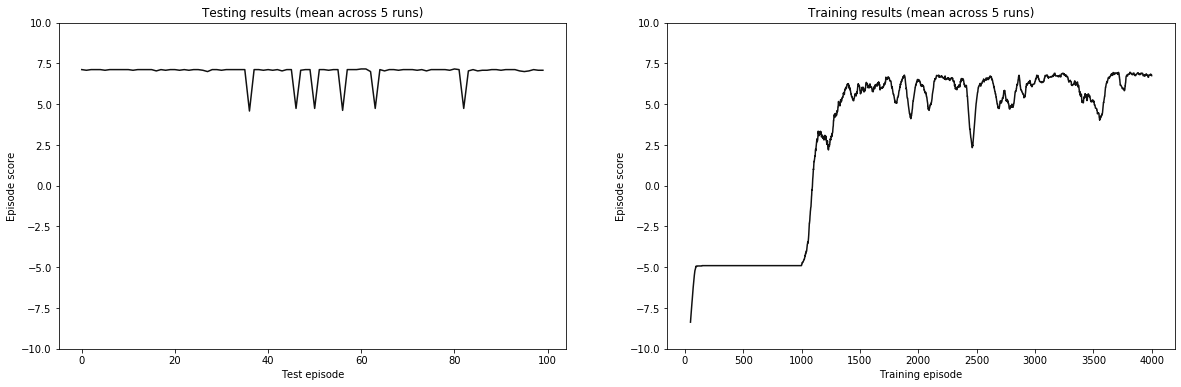

In [0]:
#@title Train and test curves { form-width: "30%" }
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

window = 50

tests_rewards_np = np.stack(tests_rewards).T
tests_rewards_mean = tests_rewards_np.mean(axis=1)
tests_rewards_std = tests_rewards_np.std(axis=1)
tests_n = list(range(tests_rewards_np.shape[0]))

training_rewards_np = np.stack(training_rewards).T
training_rewards_mean = training_rewards_np.mean(axis=1)
training_rewards_std = training_rewards_np.std(axis=1)
training_n = list(range(training_rewards_np.shape[0]))

axes[0].plot(tests_n, tests_rewards_mean, color="#111111")
# axes[0].fill_between(tests_n, tests_rewards_mean - tests_rewards_std, tests_rewards_mean + tests_rewards_std, color="#DDDDDD")

axes[1].plot(pd.Series(training_rewards_np.mean(axis=1)).rolling(window=window).mean().values, color="#111111")
# axes[1].fill_between(training_n, training_rewards_mean - training_rewards_std, training_rewards_mean + training_rewards_std, color="#DDDDDD")

axes[0].set_title('Testing results (mean across 5 runs)')
axes[0].set_xlabel('Test episode')
axes[0].set_ylabel('Episode score')
axes[0].set_ylim((-10., 10.))

axes[1].set_title('Training results (mean across 5 runs)')
axes[1].set_xlabel('Training episode')
axes[1].set_ylabel('Episode score')
axes[1].set_ylim((-10., 10.))

plt.show()

In [0]:
#@title Demo one episode { form-width: "30%" }

env = wrap_env(gym.make(ENV_NAME))
obs_n = env.reset()
done_n = [False for a in agents]

ep_reward = 0
ep_step = 0

while not all(done_n):

    action_n = [agent.act(np.array(obs_n[a] + [ep_step / STEPS_PER_EPISODE])) for a, agent in enumerate(agents)]  # note hacked obs space
    next_obs_n, reward_n, done_n, _ = env.step(action_n)

    env.render()
    time.sleep(0.25)

    obs_n = next_obs_n

    ep_reward += sum(reward_n)
    ep_step += 1

env.render()
time.sleep(2)
env.close()
print(f'Episode reward: {ep_reward:.1f}')

show_video()

Episode reward: 7.0


#### Analysis on performance

Deep RL algorithms, and off-policy value estimation methods like Q-learning in particular, are notoriously unstable. This issue is compounded by new challenges introduced in this multi-agent system – in particular the non-stationarity of the environment and partial observability of each agent.

However we were able to demonstrate near-optimal performance on `Switch2-v0` with two key modifications to the training conditions of a DDQN agent (that was implemented from scratch):

1. **Environment-wide rewards:** at each timestep in a training episode both agents are passed the current reward profile of the entire environment, rather than the agent-specific reward (ie `sum(reward_n)` vs `reward_n[{0, 1}]`). Given the cooperative nature of `Switch`, providing a learning trajectory that optimises for joint behaviour is critical to avoid the emergence of sub-optimal policies that were observed before making this change – such as each agent rushing to pass through the corridor at the beginning of each episode, blocking each other.

2. **Staggered training:** another key element for convergence is the staggered training of agents. Broadly, for a limited period of initial training we train only one agent, while holding the other to a no-op at every time step. This allows a single agent to quickly learn the optimal strategy (to head straight through the corridor to their target square – as observed via rendering the environment through training for debugging purposes). When the second agent begins to train (conditioned on both agents' rewards at every step) it is able to successfully adapt to the first agent's learnt behaviour, waiting for it to traverse the corridor before following.

In terms of agent training, based on a non-exhaustive hyperparameter search, we arrived at a setup that ran for 4,000 episodes (1,000 of which the first agent trains alone) with a relatively aggressive exploration strategy (decaying epsilon from 0.99 to 0.01 over 4,000 timesteps).

This is combined with a relative bias towards short-term experience -- restricting the memory buffer to 1,000 timesteps (from which the oldest experience is continuously dropped as new timesteps are recorded), and a high γ of 0.9 (the discount factor over future rewards used in the core Bellman equation).

Finally, we aimed to stabilise the training process with a low learning rate (0.0005), clipped gradients (between -1e1 and 1e1), and Huber/smooth L1 loss (to be more robust against outliers and exploding gradients).

Although there certainly remains room for optimisation, especially in regards to learning stability across training runs, this combination of hyperparameters produced fairly consistent positive results, with agents achieving a mean score of >7, which is close to the theoretical maximum given that each agent receives a reward of -0.1 per timestep, and it takes a combined 14 steps for each agent to reach its target.


<br>

**N.B.:** the latest version of `ma-gym` excludes the environment step count from the observation space by default, and runs for only 50 iterations. The former I have manually corrected, the latter I have not.


## Switch4-v0 (4 agents)



#### Code for Playing Switch4-v0


In [0]:
#@title Train agents on our best hyperparameter set 5 times to assess learning stability { form-width: "30%" }
import warnings
warnings.filterwarnings("ignore")

ENV_NAME = 'Switch4-v0'
MODEL_NAME = 'AC-LINx3-128'

LOG_EVERY = 500

# We use this to normalise the episode step observation
# Note that the `ma_gym` documentation states that each episode is 100 steps
# This is actually set at 50 in the source code
STEPS_PER_EPISODE = 50

tests_rewards = []
training_rewards = []

# Train 3 times to assess stability
for _ in range(3):

    print('\n')

    agents, training_reward = train(
            agent_training_episodes=2_000,
            joint_training_episodes=2_000,
            hidden_layers=64, 
            buffer_size=4_000, 
            batch_size=64, 
            start_learning_steps=2_000,
            update_target_steps=300, 
            agent_type='ddqn', 
            loss_func='huber', 
            learning_rate=0.0005,
            clip_grads=True,
            gamma=0.9,
            eps_start=0.99,
            eps_end=0.02,
            eps_decay_steps=3_000
        )

    training_rewards.append(training_reward)
    tests_rewards.append(test(agents, 100))



Ep: 500 / (Last 500) Mean: -15.6 / Min: -20.0 / Max: -14.9 / EPS: 11.1
Ep: 1000 / (Last 500) Mean: -14.9 / Min: -14.9 / Max: -14.9 / EPS: 10.6
Ep: 1500 / (Last 500) Mean: -14.9 / Min: -14.9 / Max: -14.9 / EPS: 10.4
Ep: 2000 / (Last 500) Mean: -14.9 / Min: -14.9 / Max: -14.9 / EPS: 10.4
Finished training agent 0
Now training chunk 1
Ep: 2500 / (Last 500) Mean: -12.4 / Min: -20.0 / Max: -9.8 / EPS: 8.8
Ep: 3000 / (Last 500) Mean: -10.6 / Min: -20.0 / Max: -9.8 / EPS: 7.8
Ep: 3500 / (Last 500) Mean: -10.1 / Min: -20.0 / Max: -9.8 / EPS: 7.3
Ep: 4000 / (Last 500) Mean: -10.4 / Min: -14.9 / Max: -9.8 / EPS: 6.9
Finished training agent 1
Now training chunk 2
Ep: 4500 / (Last 500) Mean: -11.8 / Min: -20.0 / Max: -4.7 / EPS: 6.2
Ep: 5000 / (Last 500) Mean: -10.3 / Min: -20.0 / Max: -4.7 / EPS: 5.8
Ep: 5500 / (Last 500) Mean: -13.8 / Min: -20.0 / Max: -4.7 / EPS: 5.4
Ep: 6000 / (Last 500) Mean: -12.5 / Min: -20.0 / Max: -4.7 / EPS: 5.1
Finished training agent 2
Now training chunk 3
Ep: 6500 /

#### Plot the Learning Curve

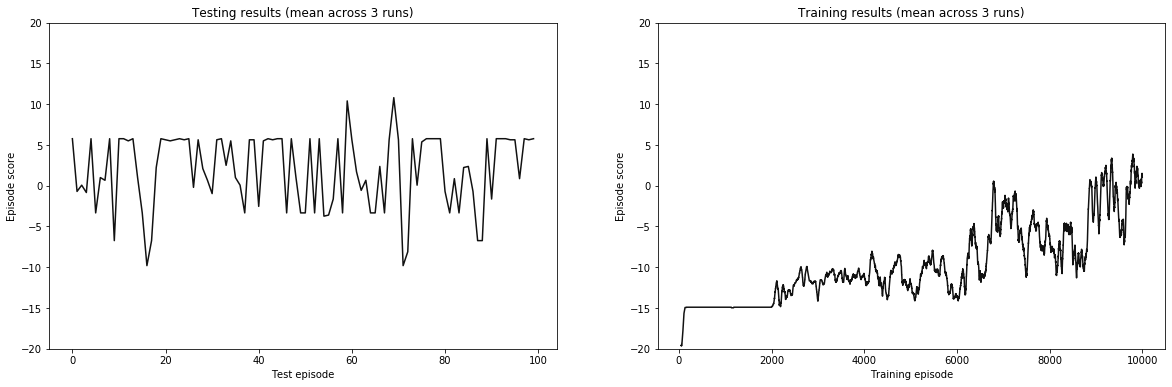

In [0]:
#@title Plot the Learning Curve { form-width: "30%" }
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

window = 50

tests_rewards_np = np.stack(tests_rewards).T
tests_rewards_mean = tests_rewards_np.mean(axis=1)
tests_rewards_std = tests_rewards_np.std(axis=1)
tests_n = list(range(tests_rewards_np.shape[0]))

training_rewards_np = np.stack(training_rewards).T
training_rewards_mean = training_rewards_np.mean(axis=1)
training_rewards_std = training_rewards_np.std(axis=1)
training_n = list(range(training_rewards_np.shape[0]))

axes[0].plot(tests_n, tests_rewards_mean, color="#111111")

axes[1].plot(pd.Series(training_rewards_np.mean(axis=1)).rolling(window=window).mean().values, color="#111111")

axes[0].set_title('Testing results (mean across 3 runs)')
axes[0].set_xlabel('Test episode')
axes[0].set_ylabel('Episode score')
axes[0].set_ylim((-20., 20.))

axes[1].set_title('Training results (mean across 3 runs)')
axes[1].set_xlabel('Training episode')
axes[1].set_ylabel('Episode score')
axes[1].set_ylim((-20., 20.))

plt.show()

In [0]:
#@title Demo one episode { form-width: "30%" }

env = wrap_env(gym.make(ENV_NAME))
obs_n = env.reset()
done_n = [False for a in agents]

ep_reward = 0
ep_step = 0

while not all(done_n):

    action_n = [agent.act(np.array(obs_n[a] + [ep_step / STEPS_PER_EPISODE])) for a, agent in enumerate(agents)]  # note hacked obs space
    next_obs_n, reward_n, done_n, _ = env.step(action_n)

    env.render()

    obs_n = next_obs_n

    ep_reward += sum(reward_n)
    ep_step += 1

env.render()
env.close()
print(f'Episode reward: {ep_reward:.1f}')

show_video()

Episode reward: 9.6


#### Analysis on Performance

Fortunately, we were able to extend the same training technique developed for `Switch2` to the `Switch4` domain without any code modifications (code was deliberately designed to generalise to more agents) -- namely the notion of incrementally training one agent at a time, while holding those that are yet to be trained to a constant no-op behaviour in order to help minimize non-stationarity in the environment in the early stages of training. 

Compared to the training regime that performed well on `Switch2`, however, we do make some key hyperparameter adjustments. 

These include: 
- A longer training time, consisting of 10,000 total episodes (introducing a new agent into the training loop ever 2,000 episodes, with 2,000 episodes of all-agent training at the end) -- vs 3,000 total for `Switch2`
- A larger buffer size (from 1,000 to 4,000 timesteps) to encourage the emergence and preservation of better cooperative strategies (such as the corridor following behaviour we see in the above video) -- but that are harder exploration problems
- A slightly higher final epsilon (from 0.01 to 0.02) and 'burn-in' period at the beginning of training (from 1,000 to 2,000 episodes) to encourage sustained greater exploration as described above
- A longer period between target network updates (from 200 to 300 timesteps) to encourage greater training stability

As can be seen via our experimental results (which average performance over 3 independent training runs), performance is generally positive but unstable. At least one of the training runs failed to converge at all, but when it did achieve a good learning trajectory performance is satisfactory, with intelligent emergent behaviours such as corridor following and coordianted movement of agents out of the way of the others on their way to their targets. 